# Covid-19 Forecasting


No contexto do COVID-19 vamos tentar prever o número de pessoas infetadas e o número de fatalidades em Portugal. Numa primeira instância vamos analisar um dataset global e tentar tirar conclusões. Depois de estar concluída a primeira análise vamos reletir sobre o caso português em concreto.

Após a exploração do dataset principal vamos tentar enriquece-lo com algumas features calculadas e tentar chegar a um modelo simples de regressão linear. De seguida iremos otimizar o modelo.

Tendo o modelo de regressão linear construído vamos explorar outros modelos clássicos de ML como SVM e Random Forests.

Por fim, vamos recorrer a RNN's para comparar com os modelos clássicos.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [2]:
kaggle_data_path = "../input/"
local_data_path = "data/"

train_dataset = pd.read_csv(kaggle_data_path + "covid19-global-forecasting-week-4/train.csv")

## **Exploração do dataset global**

In [3]:
train_dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


O dataset inicial contém apenas o número de casos confirmados e as fatalidades por país e em alguns casos por província desse país, como é o caso da China. Para melhor entender a magnitude dos dados recolhidos vamos verificar a evolução dos casos confirmados e das fatalidades desde o início da propagação do vírus e a nível global. 

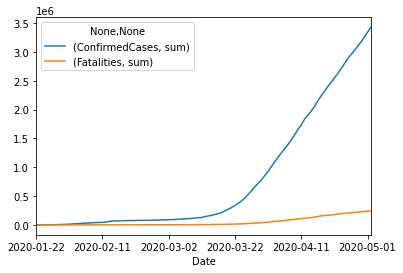

In [4]:
total_confirmed = train_dataset.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities = train_dataset.groupby(['Date']).agg({'Fatalities':['sum']})
total_confirmed.join(total_fatalities).plot()

É possível verificar que o crescimento dos casos confirmados é exponencial, estando perto dos 3.5 milhões, porém e felizmente, o número de fatalidades revela um comportamento bastante mais plano, embora esteja a aumentar. O gráfico parece ter pouca suavidade no início da propagação, o que deverá estar relacionado com o facto de ter tido apenas um foco inicial, sendo ele a China e que a avaliação de doentes infetados tenha sido mais drástica a partir de um certo ponto.

Após esta análise inicial é possível verificar que a epidemia comporta-se de maneira diferente em muitos países. Obviamente que, os números nunca poderiam ser iguais, visto que ela não começou ao mesmo tempo em todos os países, mas também não são iguais devido a um grande número de fatores, entre eles, está a densidade populacional, a idade da população, os níveis sanitários, as medidas de contenção implementadas, testes realizados e até o encobrimento de dados. Como exemplo, podemos analisar os seguinte gráficos.

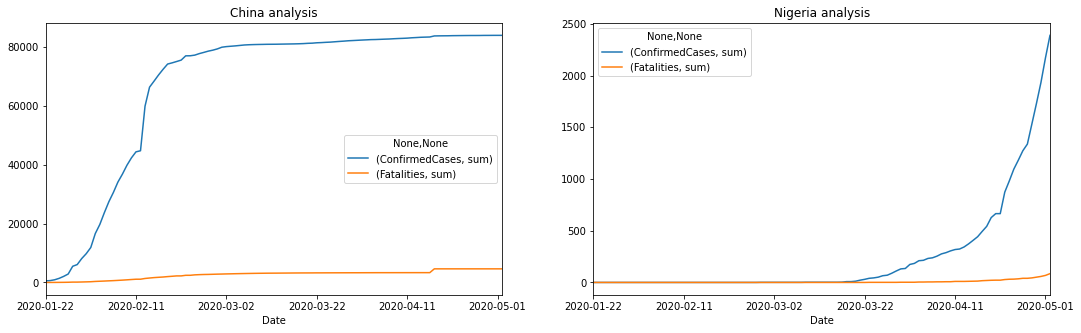

In [5]:
china_data = train_dataset[train_dataset['Country_Region'] == 'China']
total_confirmed_china = china_data.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities_china = china_data.groupby(['Date']).agg({'Fatalities':['sum']})


nigeria_data = train_dataset[train_dataset['Country_Region'] == 'Nigeria']
total_confirmed_nigeria = nigeria_data.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities_nigeria= nigeria_data.groupby(['Date']).agg({'Fatalities':['sum']})


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.set_title("China analysis")
ax2.set_title("Nigeria analysis")
total_confirmed_china.join(total_fatalities_china).plot(ax=ax1)
total_confirmed_nigeria.join(total_fatalities_nigeria).plot(ax=ax2)


Nos dois plots anteriores podemos ver dois casos que se revelam anómalos.
Em primeiro lugar, podemos olhar para a Nigeria que é um dos países com maior população do mundo e, apesar de o vírus já ter chegado a este país, ainda foram registados muitos poucos casos. Acreditamos que isto terá a ver com as inúmeras dificuldades sociais e económicas deste país o que torna complicado o acto de diagnosticar/testar e até mesmo registar os casos relacionados com o vírus.

Em segundo lugar, nada mais do que a China que apesar de ter sido o epicentro de tudo e de não estar preparada apenas reporta até à data um máximo de 4512 mortes, como podemos verificar pela tabela seguinte, sendo que o número de casos confirmados ficou bastante estagnado. Com isto, não queremos dizer que a China está a mentir nos seus números, mas é de facto um caso que revela um comportamento diferente do vírus, talvez devido às duras medidas implementadas na província de Wuhan, porém elas foram implementadas um pouco tarde.

In [6]:
china_data.describe()

,Id,ConfirmedCases,Fatalities
count,3366.000000,3366.000000,3366.000000
mean,8031.500000,2036.499109,81.211527
std,1086.057705,10179.413800,501.867762
min,6157.000000,0.000000,0.000000
25%,7094.250000,81.000000,0.000000
50%,8031.500000,206.500000,2.000000
75%,8968.750000,631.000000,4.000000
max,9906.000000,68128.000000,4512.000000


Posto isto, não faria muito sentido estar a prever a evolução desta epidemia globalmente e embora pudessemos tentar alinhar os dados dos diferentes países vamo-nos focar num país que tem sido elogiado pelo combate ao COVID-19 e cujas informações apresentadas parecem ser credíveis e que é Portugal. Com algumas pesquisas, encontramos um dataset mais detalhado sobre Portugal e com informações fornecidas pela DGS, contendo também as informações basicas fornecidas pelo anterior, sendo, assim, enriquecido.

## **Exploração do dataset de Portugal**

In [7]:
train_dataset = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
train_dataset.head(2)

,id,url,data_relatorio,suspeitos,confirmados,nao_confirmados,aguarda_resultados,recuperados,obitos,em_vigilancia,...,obitos_masculino_80_sup,obitos_feminino_0_9,obitos_feminino_10_19,obitos_feminino_20_29,obitos_feminino_30_39,obitos_feminino_40_49,obitos_feminino_50_59,obitos_feminino_60_69,obitos_feminino_70_79,obitos_feminino_80_sup
0,5,https://covid19.min-saude.pt/wp-content/upload...,2020-03-07,224,21,NaN,47.0,NaN,0,412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,https://covid19.min-saude.pt/wp-content/upload...,2020-03-08,281,30,NaN,56.0,NaN,0,447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


O dataset original não vem ordenado por dia por isso é necessário fazer essa ordenação, para além disso para já vamos converter os NaN para 0. Consideramos fazer uma interpolação para não substituir estes valores diretamente por zero, porém como eles são poucos e não se tratam de missing values, mas sim da não existência de casos de momento passarão a ser 0.

In [8]:
train_dataset = train_dataset.sort_values(by=['id'])
train_dataset = train_dataset.fillna(0).reset_index(drop='True')

Vamos então ver com mais detalhe os números portugueses.

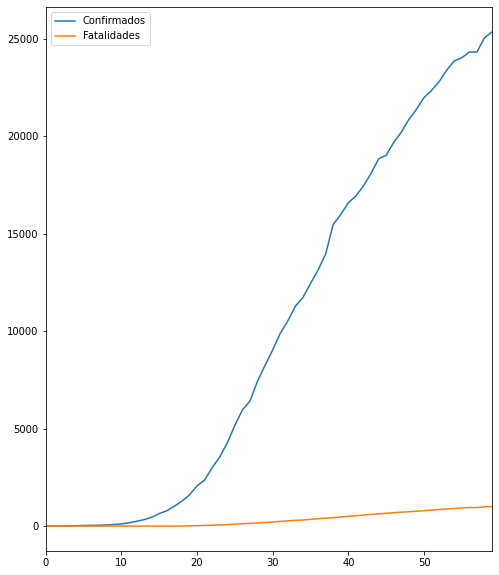

In [9]:
alvos = pd.concat([train_dataset['confirmados'],train_dataset['obitos']], axis=1, keys=['Confirmados', 'Fatalidades']).reset_index(drop='True')
alvos.plot(figsize=(8,10))

O plot anterior revela que o paradigma português, no que toca à evolução do vírus, é bastante diferente de casos mais graves, como os da Itália ou EUA, isto porque a curva não aparenta ter um crescimento exponencial, assemelhando-se mais a uma parábola considerávelmente achatada. O número de mortos é bastante reduzido, parecendo até manter-se em 0, mas isso é devido às diferenças de escalas com o número de fatalidades.

Este dataset tem muitos detalhes sobre os números do covid-19 em Portugal, chegando a ter o número de casos confirmados e obitos dividido por idades e sexo. De seguida mostra-mos apenas, como exemplo, estas divisões para os casos confirmados.

In [10]:
train_dataset[train_dataset.columns[10:19]].head()

,confirmados_masculino_0_9,confirmados_masculino_10_19,confirmados_masculino_20_29,confirmados_masculino_30_39,confirmados_masculino_40_49,confirmados_masculino_50_59,confirmados_masculino_60_69,confirmados_masculino_70_79,confirmados_masculino_80_sup
0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0
3,0.0,0.0,0.0,2.0,5.0,2.0,2.0,0.0,0.0
4,0.0,2.0,1.0,2.0,6.0,2.0,2.0,0.0,0.0


In [11]:
train_dataset[train_dataset.columns[19:28]].head()

,confirmados_feminino_0_9,confirmados_feminino_10_19,confirmados_feminino_20_29,confirmados_feminino_30_39,confirmados_feminino_40_49,confirmados_feminino_50_59,confirmados_feminino_60_69,confirmados_feminino_70_79,confirmados_feminino_80_sup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0


É importante logo à partida reduzir o número de features relevantes. Primeiro é fácil de constatar que o número de casos confirmados terá impacto direto, mais à frente, no número de mortes, isto porque as mortes, regra geral, são um subconjunto dos casos confirmados. Com isto, vamos agregar os dados de casos confirmados e de obitos por faixas etárias: Jovens (0-29), Idade Média (30-59) e Terceira Idade (60-sup), não fazendo qualquer distinção entre géneros. Pretendemos, assim, isolar a faixa determinante para o número de fatalidades no pais.

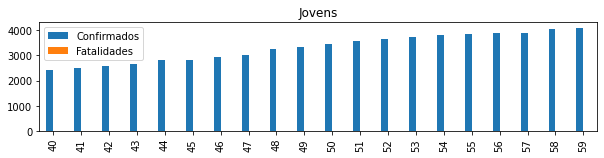

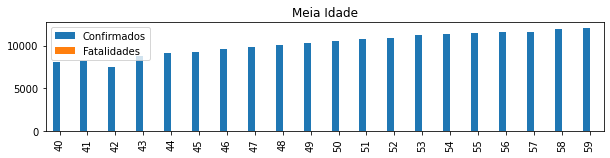

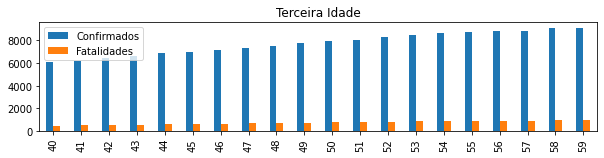

In [12]:
train_dataset = train_dataset.reset_index(drop='True')

confirmados_jovens = train_dataset['confirmados_masculino_0_9'] + train_dataset['confirmados_masculino_10_19'] + train_dataset['confirmados_masculino_20_29'] + train_dataset['confirmados_feminino_0_9'] + train_dataset['confirmados_feminino_10_19'] + train_dataset['confirmados_feminino_20_29'] 
fatalidades_jovens = train_dataset['obitos_masculino_0_9'] + train_dataset['obitos_masculino_10_19'] + train_dataset['obitos_masculino_20_29'] + train_dataset['obitos_feminino_0_9'] + train_dataset['obitos_feminino_10_19'] + train_dataset['obitos_feminino_20_29'] 
confirmados_meia_idade = train_dataset['confirmados_masculino_30_39'] + train_dataset['confirmados_masculino_40_49'] + train_dataset['confirmados_masculino_50_59'] + train_dataset['confirmados_feminino_30_39'] + train_dataset['confirmados_feminino_40_49'] + train_dataset['confirmados_feminino_50_59'] 
fatalidades_meia_idade = train_dataset['obitos_masculino_30_39'] + train_dataset['obitos_masculino_40_49'] + train_dataset['obitos_masculino_50_59']+ train_dataset['obitos_feminino_30_39'] + train_dataset['obitos_feminino_40_49'] + train_dataset['obitos_feminino_50_59'] 
confirmados_terceira_idade = train_dataset['confirmados_masculino_60_69'] + train_dataset['confirmados_masculino_70_79'] + train_dataset['confirmados_masculino_80_sup'] + train_dataset['confirmados_feminino_60_69'] + train_dataset['confirmados_feminino_70_79'] + train_dataset['confirmados_feminino_80_sup'] 
fatalidades_terceira_idade = train_dataset['obitos_masculino_60_69'] + train_dataset['obitos_masculino_70_79'] + train_dataset['obitos_masculino_80_sup'] + train_dataset['obitos_feminino_60_69'] + train_dataset['obitos_feminino_70_79'] + train_dataset['obitos_feminino_80_sup'] 


pd.concat([confirmados_jovens,fatalidades_jovens], axis=1, keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(10,2), title='Jovens')
pd.concat([confirmados_meia_idade,fatalidades_meia_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(10,2), title='Meia Idade')
pd.concat([confirmados_terceira_idade,fatalidades_terceira_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(10,2), title='Terceira Idade')

Posto isto, e como era de prever, conseguimos verificar que a população da terceira idade é a que gera o maior número de fatalidades, embora não seja a mais afetada pelo contagio, por isso vamos retirar do dataset as colunas de confirmados referentes às outras faixas etárias, porque não terão grande impacto na previsão dos casos de fatalidades. No caso dos óbitos iremos retirar as colunas todas, pois elas são apenas parte da soma que já temos e que queremos prever, sendo que apenas serviram para chegar à conclusão anterior. Iremos então manter os confirmados_terceira_idade no dataset, por agora.

Iremos aproveitar, também, para retirar já duas colunas desnecessárias. Primeiro o 'url' que apenas contém a fonte dos dados (relatório DGS) e depois a data do relatório, isto porque iremos referirmo-nos aos casos apenas como uma sequencia a partir do dia 1 (início dos dados) e até ao dia do último dado.

O dataset também inclui o total de recuperados, mas eles irão ser retirados, porque não serão o nosso foco neste trabalho. A coluna nao_confirmados irá ser retirada, pois não apresenta informação útil, assumindo que estes casos são os que foram testados e acusaram negativo (é esta a nossa interpretação). Os casos 'importados' também não revelam ser um número diferenciador para a previsão e serão removidos

In [13]:
columns1 = [x for x in range(10, 28)]
columns2 = [x for x in range(37, 55)]
train_dataset = train_dataset.drop(train_dataset.columns[columns1 + columns2], axis=1)
train_dataset = train_dataset.drop(['url', 'nao_confirmados', 'recuperados', 'data_relatorio', 'importados'], axis=1)
train_dataset.insert(2,'confirmados_terceira_idade',confirmados_terceira_idade)

In [14]:
train_dataset.head(2)

,id,suspeitos,confirmados_terceira_idade,confirmados,aguarda_resultados,obitos,em_vigilancia,internados,internados_uci,sintoma_febre,sintoma_tosse,sintoma_respiratoria,sintoma_cefaleia,sintoma_dores,sintoma_fraqueza
0,1,101,1.0,4,0.0,0,0.0,0.0,0.0,2,2,0.0,1,2,1
1,2,117,1.0,6,0.0,0,81.0,0.0,0.0,5,3,0.0,3,3,1


De seguida vamos analisar as colunas dos sintomas. 

<BarContainer object of 6 artists>

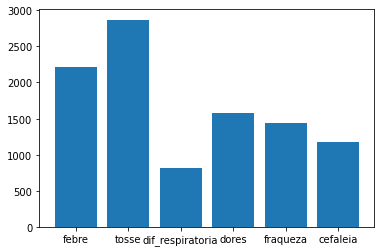

In [15]:
sintomas = []
sintomas.append(train_dataset['sintoma_febre'].sum())
sintomas.append(train_dataset['sintoma_tosse'].sum())
sintomas.append(train_dataset['sintoma_respiratoria'].sum())
sintomas.append(train_dataset['sintoma_dores'].sum())
sintomas.append(train_dataset['sintoma_cefaleia'].sum())
sintomas.append(train_dataset['sintoma_fraqueza'].sum())
plt.bar(['febre', 'tosse', 'dif_respiratoria', 'dores', 'fraqueza', 'cefaleia'], sintomas)

Claramente o maior sintoma é a tosse, porém os restantes também são bastante comuns, sendo o menos comum a dificuldade respiratória que, na nossa opinião, terá a ver com o facto de os sintomas mais comumns serem os sintomas apresentados numa fase inicial da doença e quando é feito o diagnóstico, sendo que a dificuldade respiratória será algo mais característico de fases mais avançadas da doença. 

Para a análise que vamos fazer os sintomas seriam interessantes se os conseguissemos relacionar diretamente com o número de obitos, para ver se pessoas que inicialmente apresentam determinados sintomas morrem/sobrevivem mais, mas isto com os dados presentes é algo praticamente impossível, porque os dados teriam de ter um mapeamente muito mais detalhado, relacionando obito com sintoma inicial, o que algo que não possuímos de momento, levando a um grande erro na nossa opinião, porque a morte de um paciente dependerá de inúmeros fatores.

De seguida temos uma matriz de correlações e onde, claramente, se pode ver que os sintomas apresentam correlações com as variáveis que queremos prever, e até outras features, notoriamente mais fracas que outros preditores.

Vamos proceder então à sua remoção.

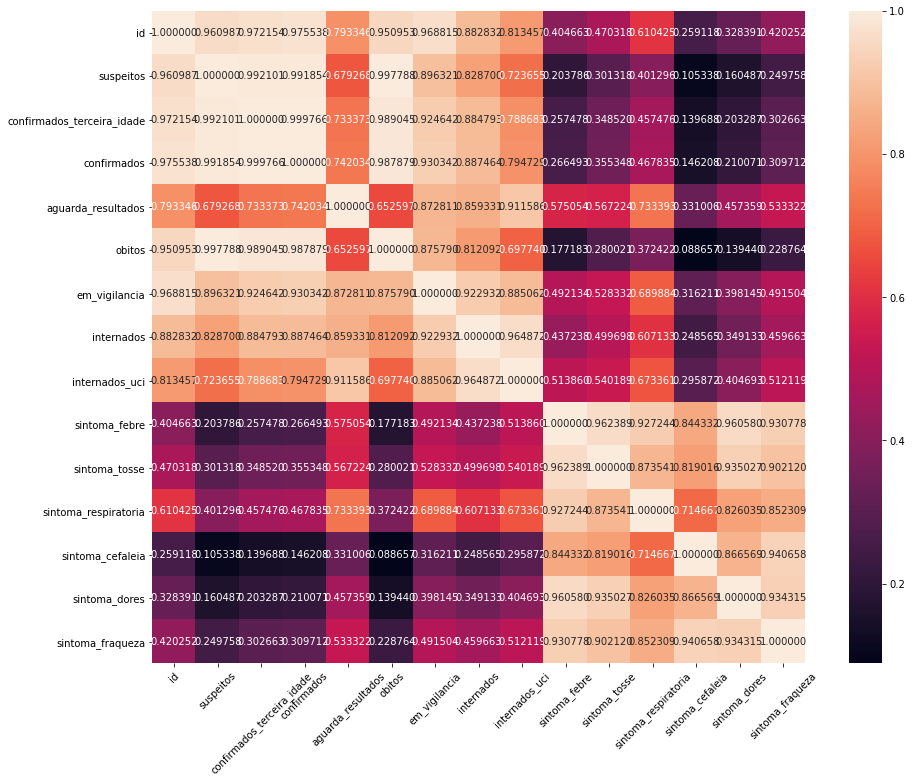

In [16]:
corr = train_dataset.corr()
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr, square=True, annot=True, fmt='.6f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [17]:
columns = [x for x in range(9, 15)]
train_dataset = train_dataset.drop(train_dataset.columns[columns], axis=1)

De seguida podemos ver as correlações das diferentes colunas com as variáveis a prever

In [18]:
train_dataset[train_dataset.columns].corr()['obitos']

id                            0.950953
suspeitos                     0.997788
confirmados_terceira_idade    0.989045
confirmados                   0.987879
aguarda_resultados            0.652597
obitos                        1.000000
em_vigilancia                 0.875790
internados                    0.812092
internados_uci                0.697740
Name: obitos, dtype: float64

In [19]:
train_dataset[train_dataset.columns].corr()['confirmados']

id                            0.975538
suspeitos                     0.991854
confirmados_terceira_idade    0.999766
confirmados                   1.000000
aguarda_resultados            0.742034
obitos                        0.987879
em_vigilancia                 0.930342
internados                    0.887464
internados_uci                0.794729
Name: confirmados, dtype: float64

Apesar dos valores das correlações mostrarem que existe uma forte ligação quase todas variáveis independentes com as variáveis dependentes, vamos dividir o dataset em 2 para chegar às duas previsões (confirmados e obitos) seguindo alguma lógica para tentar obter melhores resultados. Numa fase posterior do trabalho iremos considerar o dataset todo, para termos métodos de comparação. 

Primeiro, vamos ter um dataset (confirmados_data) para as features inerentes aos confirmados e que exclui: obitos, internados e internados_uci. Isto porque, os não faz sentido os obitos influenciarem os confirmados de dias seguintes e o mesmo para os internados e internados_uci, embora fosse possível extrair uma tendência para isso teremos outras features.

Em segundo lugar, vamos ter outro dataset (obitos_data) para as features que mais fazem sentido para os obitos e que exclui: suspeitos, aguarda_resultados e em_vigilância, que são features que farão muito mais sentido para prever confirmados.

In [20]:
confirmados_data = train_dataset.copy().drop(['obitos', 'internados', 'internados_uci'], axis=1)
obitos_data = train_dataset.copy().drop(['suspeitos', 'aguarda_resultados', 'em_vigilancia'], axis=1)
confirmados_data = confirmados_data.reset_index(drop='True')
obitos_data = obitos_data.reset_index(drop='True')

## **Enriquecimento do dataset de Portugal**

Embora seja difícil com os dados que temos estimar, em média, quanto tempo uma pessoa que faleceu permaneceu viva desde o momento em que foi diagnosticada e mesmo conseguindo o intervalo seria grande, o mesmo não se aplica ao periodo de incubação que está definido entre 1 a 14 dias. A comunidade científica não tem certezas quanto a este tempo, podendo haver flutuações no máximo de tempo que pode demorar a demonstrar sintomas, mas de momento é uma das poucas informações consencuais que existem sobre o vírus. Posto isto, vamos tentar analisar o restante dataset de acordo com este dado.

Fora colunas básicas, ainda existentes nos datasets, e já discutidas como a 'confirmados_terceira_idade' ainda falta discutir mais aprofundadamente sobre algumas colunas. Primeiro podemos abordar as colunas 'suspeitos', 'aguarda_resultado' e 'em_vigilancia', sendo que elas caem todas na mesma categoria que é a de serem um subconjunto dos casos confirmados. Embora muitos indivíduos destas categorias não estejam infetados, alguns deles podem, num futuro próximo, vir a fazer parte do grupo dos confirmados, por isso são colunas a ter em consideração. Em segundo lugar temos as colunas 'internados' e 'internados_uci' estando estas relacionadas mais com o número de obitos.

Para que isto tudo faça sentido temos de falar sobre o conceito de lags. Uma das dificuldades em prever os números desta pandemia é que observações registadas no dia X só terão impacto visível no dia X+N, podendo ser o N o periodo de incubação do vírus, ou o tempo que demora alguém contagiado a falecer. Por isso, temos de arranjar maneira de manter os valores antigos para os poder relacionar com os mais novos em relação aos anteriores. Para este efeito iremos utilizar os lags que são uma maneira de manter o valor anterior de uma coluna, introduzindo-o numa nova coluna, fazendo, basicamente, um 'shift' nos dados. 

In [21]:
def lag_calc(data, minimum, size, column):
    for lag in range(minimum, size+1):
        lag_column = column + "_lag_" + str(lag)
        data[lag_column] = data[column].shift(lag, fill_value=0)
    return data

Tendo o conceito de lag claro, vamos proceder a utilizar este cálculo para certas colunas. Vejamos então caso a caso.

Aguarda resultados: A receção de um resultado de um teste ao COVID-19 pode resultar num caso confirmado, sendo que o tempo desta receção poderá variar consoante o congestionamento do serviço de análises. Iremos tomar o princípio de que não deverá demorar mais do que 2 dias, portanto esta coluna irá dar origem a mais duas. A primeira tendo os valores da coluna em questão, mas com o 'shifts' de um dia e a segunda com um 'shift' de dois dias. Tendo um aumento significativo na correlação.

In [22]:
confirmados_data = lag_calc(confirmados_data, 1, 2, 'aguarda_resultados')

print(confirmados_data['aguarda_resultados'].corr(confirmados_data['confirmados']))
print(confirmados_data['aguarda_resultados_lag_1'].corr(confirmados_data['confirmados']))
print(confirmados_data['aguarda_resultados_lag_2'].corr(confirmados_data['confirmados']))

0.7420338963622964
0.7686653161724936
0.7939953619926425


Suspeitos e em vigilância: Estas duas colunas representam pessoas que poderão vir a ter o vírus, sendo que, pelo que percebemos, os suspeitos são aqueles que estão a demonstrar sintomas, mas ainda não foram testados e em vigilância são as pessoas que estiveram numa situação que pudesse ter levado ao possível contagio. Com isto iremos tomar em conta os 14 dias de incubação e numa primeira análise iremos ficar pelo meio, ou seja, iremos calcular o lag destes casos para 8 dias, numa primeira fase.

In [23]:
confirmados_data = lag_calc(confirmados_data, 1, 8, 'suspeitos')
confirmados_data = lag_calc(confirmados_data, 1, 8, 'em_vigilancia')

Faremos o mesmo que no caso anterior para os obitos, confirmados e confirmados_terceira_idade

In [24]:
#obitos_data = lag_calc(obitos_data, 1, 8, 'confirmados')
obitos_data = lag_calc(obitos_data, 1, 8, 'confirmados_terceira_idade')
obitos_data = lag_calc(obitos_data, 1, 8, 'obitos')
confirmados_data = lag_calc(confirmados_data, 1, 8, 'confirmados')
#confirmados_data = lag_calc(confirmados_data, 1, 8, 'confirmados_terceira_idade')

No caso dos internados e internados_uci fará sentido eles afetarem os obitos, porque geralmente as mortes são mais frequêntes nestes grupos e ainda mais nos que estão internados na uci. Posto isto verificamos qual era o dia da primeira morte (20 em relação ao primeiro dia de registos) e calculamos lags de 8 dias após esse dia, tentando simular as mortes provenientes destes grupos.

In [25]:
#primeiras mortes no dia 20

obitos_data = lag_calc(obitos_data, 20, 28, 'internados')
obitos_data = lag_calc(obitos_data, 20, 28, 'internados_uci')

Outro conceito que podemos introduzir é o tendència de um valor de um certo dia para outro da mesma coluna. E pode ser definida pelo seguinte método:

In [26]:
def trend_calc(data, minimum, size, column):
    for t in range(minimum, size+1):
        trend_column = column + "_trend_" + str(t)
        data[trend_column] = (data[column] - data[column].shift(t, fill_value=0))/data[column].shift(t, fill_value=10)
    return data

De momento só iremos calcular tendências para os confirmados e para os obitos de cada dataset.

In [27]:
#obitos_data = trend_calc(obitos_data, 1, 8, 'confirmados')
obitos_data = trend_calc(obitos_data, 1, 8, 'obitos')
obitos_data = obitos_data.fillna(0)
obitos_data.replace([np.inf], 0, inplace=True)

confirmados_data = trend_calc(confirmados_data, 1, 8, 'confirmados')

## **Modelo de Regressão Linear Inicial**

In [28]:
def data_split_for_model(data, train_count, target):
    x_train = data[data['id'] <= train_count]
    y_train = x_train[target]
    x_train = x_train.drop([target], axis=1)
    x_test = data[data['id'] > train_count].drop([target], axis=1)
    y_test = data[data['id'] > train_count][target]
    
    return x_train, y_train, x_test, y_test.to_numpy()

    
def regression(x_train, y_train, x_test):
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    return model, model.predict(x_test)

def plot_prediction(data, prediction, y_train, target, train_size):
    aux_train = y_train.copy()
    combined = pd.concat([aux_train, pd.Series(prediction)], axis=0).reset_index(drop='True')
    final = pd.concat([combined, data[target]], keys = ['previsão', 'real'], axis=1)
    ax = final.plot(figsize=(20,5))
    ax = plt.axvline(x=train_size-1, linewidth=2, ls = ':', color='grey', alpha=0.5)

In [29]:
train_size = 40

target ='confirmados'
x_train, y_train, x_test, y_test = data_split_for_model(confirmados_data, train_size,target)
model, prediction = regression(x_train, y_train, x_test)
prediction

print(mean_squared_error(y_test,prediction))
print(r2_score(y_test, prediction))

3015530.92584257
0.6048796870209385


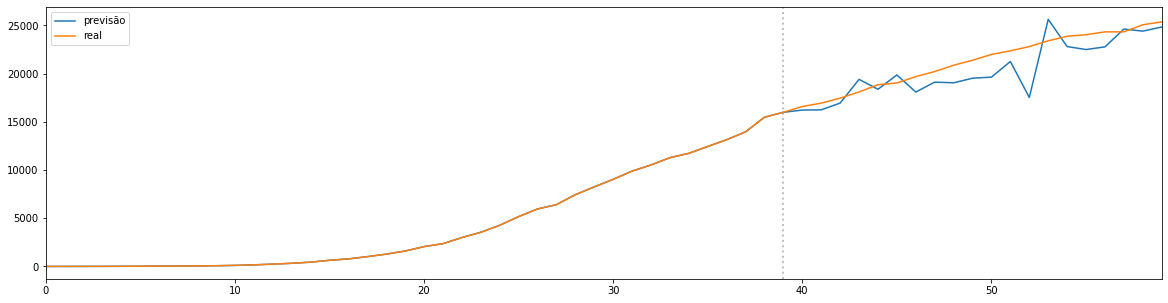

In [30]:
plot_prediction(confirmados_data, prediction, y_train, target, train_size)

In [31]:
target ='obitos'
x_train, y_train, x_test, y_test = data_split_for_model(obitos_data, train_size,target)
model, prediction = regression(x_train, y_train, x_test)
prediction

print(mean_squared_error(y_test,prediction))
print(r2_score(y_test, prediction))

858236.2788043066
-35.343079446280846


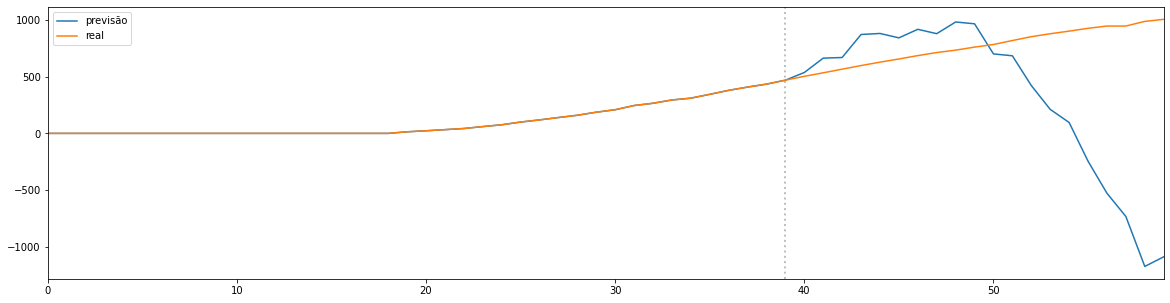

In [32]:
plot_prediction(obitos_data, prediction, y_train, target, train_size)

## **Otimização do Modelo**

[15987. 16585. 16934. 17448. 18091. 18841. 19022. 19685. 20206. 20863.
 21379. 21982. 22353. 22797. 23392. 23864. 24027. 24322. 24322. 25056.]
0.9660911762185903


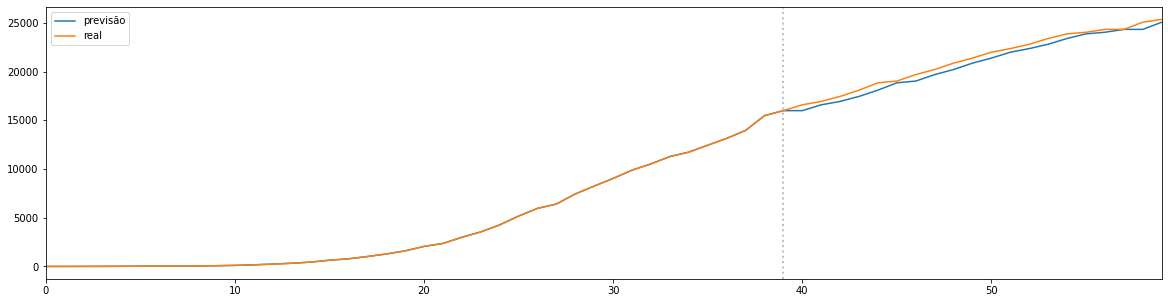

In [33]:
selector = SelectKBest(f_regression, k=4)
target ='confirmados'

x_train, y_train, x_test, y_test = data_split_for_model(confirmados_data, train_size,target)
new_x = selector.fit_transform(x_train, y_train)

cols = selector.get_support(indices=True)
features_df_new = confirmados_data.iloc[:,cols]

#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()
#print(scores)

features_df_new_test = features_df_new.loc[train_size:] 
features_df_new = features_df_new.loc[1:train_size] 

model, prediction = regression(features_df_new, y_train, features_df_new_test)

print(prediction)

plot_prediction(confirmados_data, prediction, y_train, target, train_size)
print(r2_score(y_test, prediction))

[ 463.18797438  491.61248687  508.37389309  538.32970642  574.79885522
  602.44431097  626.13375756  642.84897023  692.61639686  730.88027158
  748.28705239  768.92077665  791.44121497  871.47200564  908.21705862
  928.17480532  950.26326333  975.85324041  991.799302   1017.64508566]
0.9216919584293546


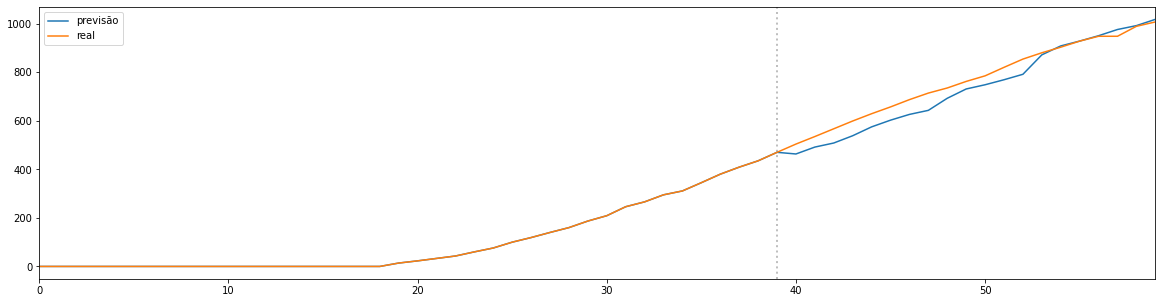

In [34]:
selector = SelectKBest(f_regression, k=4)
target ='obitos'

x_train, y_train, x_test, y_test = data_split_for_model(obitos_data, train_size,target)
new_x = selector.fit_transform(x_train, y_train)

cols = selector.get_support(indices=True)
features_df_new = confirmados_data.iloc[:,cols]

#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()
#print(scores)

features_df_new_test = features_df_new.loc[train_size:] 
features_df_new = features_df_new.loc[1:train_size] 

model, prediction = regression(features_df_new, y_train, features_df_new_test)

print(prediction)

plot_prediction(obitos_data, prediction, y_train, target, train_size)
print(r2_score(y_test, prediction))